In [ ]:
#default_exp core

In [ ]:
#export
from local.test import *
from local.imports import *
from local.notebook.showdoc import show_doc

In [ ]:
#export
if torch.cuda.is_available(): torch.cuda.set_device(int(os.environ.get('DEFAULT_GPU') or 0))

# Core

> Basic functions used in the fastai library

In [ ]:
# export
defaults = SimpleNamespace()

## Metaclasses

In [ ]:
#export
class PrePostInitMeta(type):
    "A metaclass that calls optional `__pre_init__` and `__post_init__` methods"
    def __new__(cls, name, bases, dct):
        x = super().__new__(cls, name, bases, dct)
        def _pass(self, *args,**kwargs): pass
        for o in ('__init__', '__pre_init__', '__post_init__'):
            if not hasattr(x,o): setattr(x,o,_pass)
        old_init = x.__init__
        
        @functools.wraps(old_init)
        def _init(self,*args,**kwargs):
            self.__pre_init__()
            old_init(self, *args,**kwargs)
            self.__post_init__()
        setattr(x, '__init__', _init)
        return x

In [ ]:
show_doc(PrePostInitMeta, title_level=3)

<h3 id="<code>class</code> <code>PrePostInitMeta</code>" class="doc_header"><code>class</code> <code>PrePostInitMeta</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#Metaclasses" class="source_link" style="float:right">[source]</a></h3>

> <code>PrePostInitMeta</code>(**`name`**, **`bases`**, **`dct`**) :: `type`

A metaclass that calls optional `__pre_init__` and `__post_init__` methods

In [ ]:
class _T(metaclass=PrePostInitMeta):
    def __pre_init__(self):  self.a  = 0; assert self.a==0
    def __init__(self):      self.a += 1; assert self.a==1
    def __post_init__(self): self.a += 1; assert self.a==2

t = _T()
t.a

2

In [ ]:
#export
class BaseObj(metaclass=PrePostInitMeta):
    "Base class that provides `PrePostInitMeta` metaclass to subclasses"
    pass

In [ ]:
class _T(BaseObj):
    def __pre_init__(self):  self.a  = 0; assert self.a==0
    def __init__(self):      self.a += 1; assert self.a==1
    def __post_init__(self): self.a += 1; assert self.a==2

t = _T()
t.a

2

In [ ]:
#export
class NewChkMeta(PrePostInitMeta):
    "Metaclass to avoid recreating object passed to constructor (plus all `PrePostInitMeta` functionality)"
    def __new__(cls, name, bases, dct):
        x = super().__new__(cls, name, bases, dct)
        old_init,old_new = x.__init__,x.__new__

        @functools.wraps(old_init)
        def _new(cls, x=None, *args, **kwargs):
            if x is not None and isinstance(x,cls):
                x._newchk = 1
                return x
            res = old_new(cls)
            res._newchk = 0
            return res

        @functools.wraps(old_init)
        def _init(self,*args,**kwargs):
            if self._newchk: return
            old_init(self, *args, **kwargs)

        x.__init__,x.__new__ = _init,_new
        return x

In [ ]:
class _T(metaclass=NewChkMeta):
    "Testing"
    def __init__(self, o=None): self.foo = getattr(o,'foo',0) + 1

class _T2():
    def __init__(self, o): self.foo = getattr(o,'foo',0) + 1

t = _T(1)
test_eq(t.foo,1)
t2 = _T(t)
test_eq(t2.foo,1)
test_is(t,t2)

t = _T2(1)
test_eq(t.foo,1)
t2 = _T2(t)
test_eq(t2.foo,2)

test_eq(_T.__doc__, "Testing")
test_eq(str(inspect.signature(_T)), '(o=None)')

In [ ]:
#export
class BypassNewMeta(type):
    "Metaclass: casts `x` to this class, initializing with `_new_meta` if available"
    def __call__(cls, x, *args, **kwargs):
        if hasattr(cls, '_new_meta'): x = cls._new_meta(x, *args, **kwargs)
        if cls!=x.__class__: x.__class__ = cls
        return x

In [ ]:
class T0: pass
class _T(T0, metaclass=BypassNewMeta): pass

t = T0()
t.a = 1
t2 = _T(t)
test_eq(type(t2), _T)
test_eq(t2.a,1)

## Foundational functions

### Decorators

In [ ]:
#export
def patch_to(cls, as_prop=False):
    "Decorator: add `f` to `cls`"
    def _inner(f):
        nf = copy(f)
        # `functools.update_wrapper` when passing patched function to `Pipeline`, so we do it manually
        for o in functools.WRAPPER_ASSIGNMENTS: setattr(nf, o, getattr(f,o))
        nf.__qualname__ = f"{cls.__name__}.{f.__name__}"
        setattr(cls, f.__name__, property(nf) if as_prop else nf)
        return f
    return _inner

In [ ]:
class _T3(int): pass

@patch_to(_T3)
def func1(self): return self+2

@patch_to(_T3)
def func2(self, a:int): return self+a+ 2

t = _T3(1)
test_eq(t.func1(), 3)

t2 = _T3(1)
test_eq(t.func2(2), 5)

In [ ]:
#export
def patch(f):
    "Decorator: add `f` to the first parameter's class (based on f's type annotations)"
    cls = next(iter(f.__annotations__.values()))
    return patch_to(cls)(f)

In [ ]:
@patch
def func(self:_T3):
    "test"
    return self+2

@patch
def func1(self:_T3, a:int):
    "test"
    return self+2+a

t = _T3(1)
test_eq(t.func(), 3)
test_eq(t.func.__qualname__, '_T3.func')

t = _T3(1)
test_eq(t.func1(2), 5)
test_eq(t.func1.__qualname__, '_T3.func1')

In [ ]:
#export
def patch_property(f):
    "Decorator: add `f` as a property to the first parameter's class (based on f's type annotations)"
    cls = next(iter(f.__annotations__.values()))
    return patch_to(cls, as_prop=True)(f)

In [ ]:
@patch_property
def prop(self:_T3): return self+1

t = _T3(1)
test_eq(t.prop, 2)

In [ ]:
#export
def _mk_param(n,d=None): return inspect.Parameter(n, inspect.Parameter.KEYWORD_ONLY, default=d)

In [ ]:
def test_sig(f, b): test_eq(str(inspect.signature(f)), b)

In [ ]:
#export
def use_kwargs(names, keep=False):
    "Decorator: replace `**kwargs` in signature with `names` params"
    def _f(f):
        sig = inspect.signature(f)
        sigd = dict(sig.parameters)
        k = sigd.pop('kwargs')
        s2 = {n:_mk_param(n) for n in names if n not in sigd}
        sigd.update(s2)
        if keep: sigd['kwargs'] = k
        f.__signature__ = sig.replace(parameters=sigd.values())
        return f
    return _f

In [ ]:
@use_kwargs(['y', 'z'])
def foo(a, b=1, **kwargs): pass
test_sig(foo, '(a, b=1, *, y=None, z=None)')

@use_kwargs(['y', 'z'], keep=True)
def foo(a, *args, b=1, **kwargs): pass
test_sig(foo, '(a, *args, b=1, y=None, z=None, **kwargs)')

In [ ]:
#export
def delegates(to=None, keep=False):
    "Decorator: replace `**kwargs` in signature with params from `to`"
    def _f(f):
        if to is None: to_f,from_f = f.__base__.__init__,f.__init__
        else:          to_f,from_f = to,f
        sig = inspect.signature(from_f)
        sigd = dict(sig.parameters)
        k = sigd.pop('kwargs')
        s2 = {k:v for k,v in inspect.signature(to_f).parameters.items()
              if v.default != inspect.Parameter.empty and k not in sigd}
        sigd.update(s2)
        if keep: sigd['kwargs'] = k
        from_f.__signature__ = sig.replace(parameters=sigd.values())
        return f
    return _f

In [ ]:
def basefoo(e, c=2): pass

@delegates(basefoo)
def foo(a, b=1, **kwargs): pass
test_sig(foo, '(a, b=1, c=2)')

@delegates(basefoo, keep=True)
def foo(a, b=1, **kwargs): pass
test_sig(foo, '(a, b=1, c=2, **kwargs)')

In [ ]:
class BaseFoo:
    def __init__(self, e, c=2): pass

@delegates()
class Foo(BaseFoo):
    def __init__(self, a, b=1, **kwargs): super().__init__(**kwargs)

test_sig(Foo, '(a, b=1, c=2)')

In [ ]:
#export
def funcs_kwargs(cls):
    "Replace methods in `self._methods` with those from `kwargs`"
    old_init = cls.__init__
    def _init(self, *args, **kwargs):
        for k in cls._methods:
            arg = kwargs.pop(k,None)
            if arg is not None:
                if isinstance(arg,types.MethodType): arg = types.MethodType(arg.__func__, self)
                setattr(self, k, arg)
        old_init(self, *args, **kwargs)
    functools.update_wrapper(_init, old_init)
    cls.__init__ = use_kwargs(cls._methods)(_init)
    return cls

In [ ]:
#export
def method(f):
    "Mark `f` as a method"
    # `1` is a dummy instance since Py3 doesn't allow `None` any more
    return types.MethodType(f, 1)

In [ ]:
@funcs_kwargs
class T:
    _methods=['b']
    def __init__(self, f=1, **kwargs): assert not kwargs
    def a(self): return 1
    def b(self): return 2
    
t = T()
test_eq(t.a(), 1)
test_eq(t.b(), 2)
t = T(b = lambda:3)
test_eq(t.b(), 3)
test_sig(T, '(f=1, *, b=None)')
test_fail(lambda: T(a = lambda:3))

@method
def _f(self,a=1): return a+1
t = T(b = _f)
test_eq(t.b(2), 3)

class T2(T):
    def __init__(self,a):
        super().__init__(b = lambda:3)
        self.a=a
t = T2(a=1)
test_eq(t.b(), 3)
test_sig(T2, '(a)')

def _g(a=1): return a+1
class T3(T): b = staticmethod(_g)
t = T3()
test_eq(t.b(2), 3)

### Type checking

Runtime type checking is handy, so let's make it easy!

In [ ]:
#export core
#NB: Please don't move this to a different line or module, since it's used in testing `get_source_link`
def chk(f): return typechecked(always=True)(f)

Decorator for a function to check that type-annotated arguments receive arguments of the right type.

In [ ]:
@chk
def test_chk(a:int=1): return a

test_eq(test_chk(2), 2)
test_eq(test_chk(), 1)
test_fail(lambda: test_chk('a'), contains='"a" must be int')

Decorated functions will pickle correctly.

In [ ]:
t = pickle.loads(pickle.dumps(test_chk))
test_eq(t(2), 2)
test_eq(t(), 1)

### Context managers

In [ ]:
@contextmanager
def working_directory(path):
    "Change working directory to `path` and return to previous on exit."
    prev_cwd = Path.cwd()
    os.chdir(path)
    try: yield
    finally: os.chdir(prev_cwd)

### Monkey-patching

In [ ]:
def is_listy(x): return isinstance(x,(list,tuple,Generator))

In [ ]:
#export
def tensor(x, *rest, **kwargs):
    "Like `torch.as_tensor`, but handle lists too, and can pass multiple vector elements directly."
    if len(rest): x = (x,)+rest
    # Pytorch bug in dataloader using num_workers>0
    if isinstance(x, (tuple,list)) and len(x)==0: return tensor(0)
    res = (torch.tensor(x, **kwargs) if isinstance(x, (tuple,list))
           else as_tensor(x, **kwargs) if hasattr(x, '__array__')
           else as_tensor(x, **kwargs) if is_listy(x)
           else as_tensor(x, **kwargs) if is_iter(x)
           else None)
    if res is None:
        res = as_tensor(array(x), **kwargs)
        if res.dtype is torch.float64: return res.float()
    if res.dtype is torch.int32:
        warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
        return res.long()
    return res

In [ ]:
test_eq(tensor(array([1,2,3])), torch.tensor([1,2,3]))
test_eq(tensor(1,2,3), torch.tensor([1,2,3]))
test_eq_type(tensor(1.0), torch.tensor(1.0))

#### `Tensor.ndim`

We add an `ndim` property to `Tensor` with same semantics as [numpy ndim](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.ndim.html), which allows tensors to be used in matplotlib and other places that assume this property exists.

In [ ]:
test_eq(torch.tensor([1,2]).ndim,1)
test_eq(torch.tensor(1).ndim,0)
test_eq(torch.tensor([[1]]).ndim,2)

### Documentation functions

In [ ]:
#export core
def add_docs(cls, cls_doc=None, **docs):
    "Copy values from `docs` to `cls` docstrings, and confirm all public methods are documented"
    if cls_doc is not None: cls.__doc__ = cls_doc
    for k,v in docs.items():
        f = getattr(cls,k)
        if hasattr(f,'__func__'): f = f.__func__ # required for class methods
        f.__doc__ = v
    # List of public callables without docstring
    nodoc = [c for n,c in vars(cls).items() if isinstance(c,Callable)
             and not n.startswith('_') and c.__doc__ is None]
    assert not nodoc, f"Missing docs: {nodoc}"
    assert cls.__doc__ is not None, f"Missing class docs: {cls}"

In [ ]:
#export core
def docs(cls):
    "Decorator version of `add_docs`, using `_docs` dict"
    add_docs(cls, **cls._docs)
    return cls

In [ ]:
class _T:
    def f(self): pass
    @classmethod
    def g(cls): pass
add_docs(_T, "a", f="f", g="g")

test_eq(_T.__doc__, "a")
test_eq(_T.f.__doc__, "f")
test_eq(_T.g.__doc__, "g")

In [ ]:
#export
def custom_dir(c, add:List):
    "Implement custom `__dir__`, adding `add` to `cls`"
    return dir(type(c)) + list(c.__dict__.keys()) + add

In [ ]:
show_doc(is_iter)

<h4 id="<code>is_iter</code>" class="doc_header"><code>is_iter</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/local/imports.py#L47" class="source_link" style="float:right">[source]</a></h4>

> <code>is_iter</code>(**`o`**)

Test whether `o` can be used in a `for` loop

In [ ]:
assert is_iter([1])
assert not is_iter(torch.tensor(1))
assert is_iter(torch.tensor([1,2]))
assert (o for o in range(3))

## GetAttr -

In [ ]:
#export
class GetAttr(BaseObj):
    "Inherit from this to have all attr accesses in `self._xtra` passed down to `self.default`"
    @property
    def _xtra(self): return [o for o in dir(self.default) if not o.startswith('_')]
    def __getattr__(self,k):
        if k in self._xtra: return getattr(self.default, k)
        raise AttributeError(k)
    def __dir__(self): return custom_dir(self, self._xtra)

In [ ]:
class _C(GetAttr): default,_xtra = 'Hi',['lower']

t = _C()
test_eq(t.lower(), 'hi')
test_fail(lambda: t.upper())
assert 'lower' in dir(t)

In [ ]:
#export
def delegate_attr(self, k, to):
    "Use in `__getattr__` to delegate to attr `to` without inheriting from `GetAttr`"
    if k.startswith('_') or k==to: raise AttributeError(k)
    try: return getattr(getattr(self,to), k)
    except AttributeError: raise AttributeError(k) from None

In [ ]:
class _C:
    f = 'Hi'
    def __getattr__(self, k): return delegate_attr(self, k, 'f')

t = _C()
test_eq(t.lower(), 'hi')

## L -

In [ ]:
# export
def coll_repr(c, max_n=10):
    "String repr of up to `max_n` items of (possibly lazy) collection `c`"
    return f'(#{len(c)}) [' + ','.join(itertools.islice(map(str,c), max_n)) + ('...'
            if len(c)>10 else '') + ']'

In [ ]:
test_eq(coll_repr(range(1000), 5), '(#1000) [0,1,2,3,4...]')

In [ ]:
# export
def mask2idxs(mask):
    "Convert bool mask or index list to index `L`"
    mask = list(mask)
    if len(mask)==0: return []
    if isinstance(mask[0],bool): return [i for i,m in enumerate(mask) if m]
    return [int(i) for i in mask]

In [ ]:
test_eq(mask2idxs([False,True,False,True]), [1,3])
test_eq(mask2idxs(torch.tensor([1,2,3])), [1,2,3])

In [ ]:
# export
def _listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, (str,np.ndarray,Tensor)): return [o]
    if is_iter(o): return list(o)
    return [o]

In [ ]:
#export
class CollBase(GetAttr, metaclass=NewChkMeta):
    "Base class for composing a list of `items`"
    _xtra =  [o for o in dir([]) if not o.startswith('_')]

    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, k): return self.items[k]
    def __setitem__(self, k, v): self.items[k] = v
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self): return self.items.__repr__()
    def __iter__(self): return self.items.__iter__()
    def _new(self, items, *args, **kwargs): return self.__class__(items, *args, **kwargs)
    @property
    def default(self): return self.items

In [ ]:
#export
class L(CollBase):
    "Behaves like a list of `items` but can also index with list of indices or masks"
    def __init__(self, items=None, *rest, use_list=False, match=None):
        if rest: items = (items,)+rest
        if items is None: items = []
        if (use_list is not None) or not isinstance(items,(Tensor,ndarray,pd.DataFrame,pd.Series)):
            items = list(items) if use_list else _listify(items)
        if match is not None:
            if len(items)==1: items = items*len(match)
            else: assert len(items)==len(match), 'Match length mismatch'
        super().__init__(items)
        
    def __getitem__(self, idx): return L(self._gets(idx), use_list=None) if is_iter(idx) else self._get(idx)
    def _get(self, i): return getattr(self.items,'iloc',self.items)[i]
    def _gets(self, i):
        i = mask2idxs(i)
        return (self.items.iloc[list(i)] if hasattr(self.items,'iloc')
                else self.items.__array__()[(i,)] if hasattr(self.items,'__array__')
                else [self.items[i_] for i_ in i])
    
    def __setitem__(self, idx, o):
        "Set `idx` (can be list of indices, or mask, or int) items to `o` (which is broadcast if not iterable)"
        idx = idx if isinstance(idx,L) else _listify(idx) 
        if not is_iter(o): o = [o]*len(idx)
        for i,o_ in zip(idx,o): self.items[i] = o_
    
    def __repr__(self): return coll_repr(self)
    def __eq__(self,b): return all_equal(b,self)
    def __iter__(self): return (self[i] for i in range(len(self)))
    
    def __invert__(self): return self._new(not i for i in self)
    def __mul__ (a,b): return a._new(a.items*b)
    def __add__ (a,b): return a._new(a.items+_listify(b))
    def __radd__(a,b): return a._new(b)+a
    def __addi__(a,b):
        a.items += list(b)
        return a

    def sorted(self, key=None, reverse=False):
        "New `L` sorted by `key`. If key is str then use `attrgetter`. If key is int then use `itemgetter`."
        if isinstance(key,str):   k=lambda o:getattr(o,key,0)
        elif isinstance(key,int): k=itemgetter(key)
        else: k=key
        return self._new(sorted(self.items, key=k, reverse=reverse))
    
    @classmethod
    def range(cls, a, b=None, step=None):
        "Same as builtin `range`, but returns an `L`. Can pass a collection for `a`, to use `len(a)`"
        if is_coll(a): a = len(a)
        return cls(range(a,b,step) if step is not None else range(a,b) if b is not None else range(a))
    
    def itemgot(self, idx): return self.mapped(itemgetter(idx))
    def attrgot(self, k, default=None): return self.mapped(lambda o:getattr(o,k,default))
    def tensored(self): return self.mapped(tensor)
    def stack(self, dim=0): return torch.stack(list(self.tensored()), dim=dim)
    def cat  (self, dim=0): return torch.cat  (list(self.tensored()), dim=dim)
    def cycle(self): return itertools.cycle(self) if len(self) > 0 else itertools.cycle([None])
    def filtered(self, f, *args, **kwargs): return self._new(filter(partial(f,*args,**kwargs), self))
    def mapped(self, f, *args, **kwargs): return self._new(map(partial(f,*args,**kwargs), self))
    def mapped_dict(self, f, *args, **kwargs): return {k:f(k, *args,**kwargs) for k in self}
    def starmapped(self, f, *args, **kwargs): return self._new(itertools.starmap(partial(f,*args,**kwargs), self))
    def zipped(self, longest=False): return self._new((zip_longest if longest else zip)(*self))
    def zipwith(self, *rest, longest=False): return self._new([self, *rest]).zipped(longest=longest)
    def mapped_zip(self, f, longest=False): return self.zipped(longest=longest).starmapped(f)
    def mapped_zipwith(self, f, *rest, longest=False): return self.zipwith(*rest, longest=longest).starmapped(f)
    def shuffled(self):
        it = copy(self.items)
        random.shuffle(it)
        return self._new(it)

In [ ]:
#export
add_docs(L,
         __getitem__="Retrieve `idx` (can be list of indices, or mask, or int) items",
         filtered="Create new `L` filtered by predicate `f`, passing `args` and `kwargs` to `f`",
         mapped="Create new `L` with `f` applied to all `items`, passing `args` and `kwargs` to `f`",
         mapped_dict="Like `mapped`, but creates a dict from `items` to function results",
         starmapped="Like `mapped`, but use `itertools.starmap`",
         itemgot="Create new `L` with item `idx` of all `items`",
         attrgot="Create new `L` with attr `k` of all `items`",
         tensored="`mapped(tensor)`",
         cycle="Same as `itertools.cycle`",
         stack="Same as `torch.stack`",
         cat="Same as `torch.cat`",
         zipped="Create new `L` with `zip(*items)`",
         zipwith="Create new `L` with `self` zipped with each of `*rest`",
         mapped_zip="Combine `zipped` and `starmapped`",
         mapped_zipwith="Combine `zipwith` and `starmapped`",
         shuffled="Same as `random.shuffle`, but not inplace")

You can create an `L` from an existing iterable (e.g. a list, range, etc) and access or modify it with an int list/tuple index, mask, int, or slice. All `list` methods can also be used with `L`.

In [ ]:
t = L(range(12))
test_eq(t, list(range(12)))
test_ne(t, list(range(11)))
t.reverse()
test_eq(t[0], 11)
t[3] = "h"
test_eq(t[3], "h")
t[3,5] = ("j","k")
test_eq(t[3,5], ["j","k"])
test_eq(t, L(t))
t

(#12) [11,10,9,j,7,k,5,4,3,2...]

There are optimized indexers for arrays, tensors, and DataFrames.

In [ ]:
arr = np.arange(9).reshape(3,3)
t = L(arr, use_list=None)
test_eq(t[1,2], arr[[1,2]])

arr = torch.arange(9).view(3,3)
t = L(arr, use_list=None)
test_eq(t[1,2], arr[[1,2]])

df = pd.DataFrame({'a':[1,2,3]})
t = L(df, use_list=None)
test_eq(t[1,2], L(pd.DataFrame({'a':[2,3]}), use_list=None))

You can also modify an `L` with `append`, `+`, and `*`.

In [ ]:
t = L()
test_eq(t, [])
t.append(1)
test_eq(t, [1])
t += [3,2]
test_eq(t, [1,3,2])
t = t + [4]
test_eq(t, [1,3,2,4])
t = 5 + t
test_eq(t, [5,1,3,2,4])
test_eq(L(1,2,3), [1,2,3])
test_eq(L(1,2,3), L(1,2,3))
t = L(1)*5
t = t.mapped(operator.neg)
test_eq(t,[-1]*5)
test_eq(~L([True,False,False]), L([False,True,True]))
t = L(range(4))
test_eq(zip(t, L(1).cycle()), zip(range(4),(1,1,1,1)))
t = L.range(100)
t2 = t.shuffled()
test_ne(t,t2)
test_eq(L.range(100), t)
test_eq(set(t),set(t2))

In [ ]:
def _f(x,a=0): return x+a
t = L(1)*5
test_eq(t.mapped(_f), t)
test_eq(t.mapped(_f,1), [2]*5)
test_eq(t.mapped(_f,a=2), [3]*5)

An `L` can be constructed from anything iterable, although tensors and arrays will not be iterated over on construction, unless you pass `use_list` to the constructor.

In [ ]:
test_eq(L([1,2,3]),[1,2,3])
test_eq(L(L([1,2,3])),[1,2,3])
test_ne(L([1,2,3]),[1,2,])
test_eq(L('abc'),['abc'])
test_eq(L(range(0,3)),[0,1,2])
test_eq(L(o for o in range(0,3)),[0,1,2])
test_eq(L(tensor(0)),[tensor(0)])
test_eq(L([tensor(0),tensor(1)]),[tensor(0),tensor(1)])
test_eq(L(tensor([0.,1.1]))[0],tensor([0.,1.1]))
test_eq(L(tensor([0.,1.1]), use_list=True), [0.,1.1])  # `use_list=True` to unwrap arrays/tensors

If `match` is not `None` then the created list is same len as `match`, either by:

- If `len(items)==1` then `items` is replicated,
- Otherwise an error is raised if `match` and `items` are not already the same size.

In [ ]:
test_eq(L(1,match=[1,2,3]),[1,1,1])
test_eq(L([1,2],match=[2,3]),[1,2])
test_fail(lambda: L([1,2],match=[1,2,3]))

If you create an `L` from an existing `L` then you'll get back the original object (since `L` uses the `NewChkMeta` metaclass).

In [ ]:
test_is(L(t), t)

### Methods

In [ ]:
show_doc(L.__getitem__)

<h4 id="<code>L.__getitem__</code>" class="doc_header"><code>L.__getitem__</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.__getitem__</code>(**`idx`**)

Retrieve `idx` (can be list of indices, or mask, or int) items

In [ ]:
t = L(range(12))
test_eq(t[1,2], [1,2])                # implicit tuple
test_eq(t[[1,2]], [1,2])              # list
test_eq(t[:3], [0,1,2])               # slice
test_eq(t[[False]*11 + [True]], [11]) # mask
test_eq(t[tensor(3)], 3)

In [ ]:
show_doc(L.__setitem__)

<h4 id="<code>L.__setitem__</code>" class="doc_header"><code>L.__setitem__</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.__setitem__</code>(**`idx`**, **`o`**)

Set `idx` (can be list of indices, or mask, or int) items to `o` (which is broadcast if not iterable)

In [ ]:
t[4,6] = 0
test_eq(t[4,6], [0,0])
t[4,6] = [1,2]
test_eq(t[4,6], [1,2])

In [ ]:
show_doc(L.filtered)

<h4 id="<code>L.filtered</code>" class="doc_header"><code>L.filtered</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.filtered</code>(**`f`**, **\*`args`**, **\*\*`kwargs`**)

Create new [`L`](/core.html#L) filtered by predicate `f`, passing `args` and `kwargs` to `f`

In [ ]:
test_eq(t.filtered(lambda o:o<5), [0,1,2,3,1,2])

In [ ]:
show_doc(L.mapped)

<h4 id="<code>L.mapped</code>" class="doc_header"><code>L.mapped</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.mapped</code>(**`f`**, **\*`args`**, **\*\*`kwargs`**)

Create new [`L`](/core.html#L) with `f` applied to all `items`, passing `args` and `kwargs` to `f`

In [ ]:
test_eq(L(range(4)).mapped(operator.neg), [0,-1,-2,-3])

In [ ]:
show_doc(L.mapped_dict)

<h4 id="<code>L.mapped_dict</code>" class="doc_header"><code>L.mapped_dict</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.mapped_dict</code>(**`f`**, **\*`args`**, **\*\*`kwargs`**)

Like `mapped`, but creates a dict from `items` to function results

In [ ]:
test_eq(L(range(1,5)).mapped_dict(operator.neg), {1:-1, 2:-2, 3:-3, 4:-4})

In [ ]:
show_doc(L.zipped)

<h4 id="<code>L.zipped</code>" class="doc_header"><code>L.zipped</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.zipped</code>(**`longest`**=*`False`*)

Create new [`L`](/core.html#L) with `zip(*items)`

In [ ]:
t = L([[1,2,3],'abc'])
test_eq(t.zipped(), [(1, 'a'),(2, 'b'),(3, 'c')])

In [ ]:
t = L([[1,2],'abc'])
test_eq(t.zipped(longest=True ), [(1, 'a'),(2, 'b'),(None, 'c')])
test_eq(t.zipped(longest=False), [(1, 'a'),(2, 'b')])

In [ ]:
show_doc(L.mapped_zip)

<h4 id="<code>L.mapped_zip</code>" class="doc_header"><code>L.mapped_zip</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.mapped_zip</code>(**`f`**, **`longest`**=*`False`*)

Combine `zipped` and `starmapped`

In [ ]:
t = L([1,2,3],[2,3,4])
test_eq(t.mapped_zip(operator.mul), [2,6,12])

In [ ]:
show_doc(L.zipwith)

<h4 id="<code>L.zipwith</code>" class="doc_header"><code>L.zipwith</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.zipwith</code>(**\*`rest`**, **`longest`**=*`False`*)

Create new [`L`](/core.html#L) with `self` zipped with each of `*rest`

In [ ]:
b = [[0],[1],[2,2]]
t = L([1,2,3]).zipwith(b)
test_eq(t, [(1,[0]), (2,[1]), (3,[2,2])])

In [ ]:
show_doc(L.mapped_zipwith)

<h4 id="<code>L.mapped_zipwith</code>" class="doc_header"><code>L.mapped_zipwith</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.mapped_zipwith</code>(**`f`**, **\*`rest`**, **`longest`**=*`False`*)

Combine `zipwith` and `starmapped`

In [ ]:
test_eq(L(1,2,3).mapped_zipwith(operator.mul, [2,3,4]), [2,6,12])

In [ ]:
show_doc(L.itemgot)

<h4 id="<code>L.itemgot</code>" class="doc_header"><code>L.itemgot</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.itemgot</code>(**`idx`**)

Create new [`L`](/core.html#L) with item `idx` of all `items`

In [ ]:
test_eq(t.itemgot(1), b)

In [ ]:
show_doc(L.attrgot)

<h4 id="<code>L.attrgot</code>" class="doc_header"><code>L.attrgot</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.attrgot</code>(**`k`**, **`default`**=*`None`*)

Create new [`L`](/core.html#L) with attr `k` of all `items`

In [ ]:
a = [SimpleNamespace(a=3,b=4),SimpleNamespace(a=1,b=2)]
test_eq(L(a).attrgot('b'), [4,2])

In [ ]:
show_doc(L.sorted)

<h4 id="<code>L.sorted</code>" class="doc_header"><code>L.sorted</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.sorted</code>(**`key`**=*`None`*, **`reverse`**=*`False`*)

New [`L`](/core.html#L) sorted by `key`. If key is str then use `attrgetter`. If key is int then use `itemgetter`.

In [ ]:
test_eq(L(a).sorted('a').attrgot('b'), [2,4])

In [ ]:
show_doc(L.range)

<h4 id="<code>L.range</code>" class="doc_header"><code>L.range</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.range</code>(**`a`**, **`b`**=*`None`*, **`step`**=*`None`*)

Same as builtin `range`, but returns an [`L`](/core.html#L). Can pass a collection for `a`, to use `len(a)`

In [ ]:
test_eq_type(L.range([1,1,1]), L(range(3)))
test_eq_type(L.range(5,2,2), L(range(5,2,2)))

In [ ]:
show_doc(L.tensored)

<h4 id="<code>L.tensored</code>" class="doc_header"><code>L.tensored</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.tensored</code>()

`mapped(tensor)`

There are shortcuts for `torch.stack` and `torch.cat` if your `L` contains tensors or something convertible. You can manually convert with `tensored`.

In [ ]:
t = L(([1,2],[3,4]))
test_eq(t.tensored(), [tensor(1,2),tensor(3,4)])

In [ ]:
show_doc(L.stack)

<h4 id="<code>L.stack</code>" class="doc_header"><code>L.stack</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.stack</code>(**`dim`**=*`0`*)

Same as `torch.stack`

In [ ]:
test_eq(t.stack(), tensor([[1,2],[3,4]]))

In [ ]:
show_doc(L.cat)

<h4 id="<code>L.cat</code>" class="doc_header"><code>L.cat</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.cat</code>(**`dim`**=*`0`*)

Same as `torch.cat`

In [ ]:
test_eq(t.cat(), tensor([1,2,3,4]))

## Utility functions

### Basics

In [ ]:
# export
def ifnone(a, b):
    "`b` if `a` is None else `a`"
    return b if a is None else a

Since `b if a is None else a` is such a common pattern, we wrap it in a function. However, be careful, because python will evaluate *both* `a` and `b` when calling `ifnone` (which it doesn't do if using the `if` version directly).

In [ ]:
test_eq(ifnone(None,1), 1)
test_eq(ifnone(2   ,1), 2)

In [ ]:
#export
def get_class(nm, *fld_names, sup=None, doc=None, funcs=None, **flds):
    "Dynamically create a class, optionally inheriting from `sup`, containing `fld_names`"
    attrs = {}
    for f in fld_names: attrs[f] = None
    for f in L(funcs): attrs[f.__name__] = f
    for k,v in flds.items(): attrs[k] = v
    sup = ifnone(sup, ())
    if not isinstance(sup, tuple): sup=(sup,)
    
    def _init(self, *args, **kwargs):
        for i,v in enumerate(args): setattr(self, list(attrs.keys())[i], v)
        for k,v in kwargs.items(): setattr(self,k,v)
            
    def _repr(self):
        return '\n'.join(f'{o}: {getattr(self,o)}' for o in set(dir(self))
                         if not o.startswith('_') and not isinstance(getattr(self,o), types.MethodType))
    
    if not sup: attrs['__repr__'] = _repr
    attrs['__init__'] = _init
    res = type(nm, sup, attrs)
    if doc is not None: res.__doc__ = doc
    return res

In [ ]:
_t = get_class('_t', 'a', b=2)
t = _t()
test_eq(t.a, None)
test_eq(t.b, 2)
t = _t(1, b=3)
test_eq(t.a, 1)
test_eq(t.b, 3)
t = _t(1, 3)
test_eq(t.a, 1)
test_eq(t.b, 3)

Most often you'll want to call `mk_class`, since it adds the class to your module. See `mk_class` for more details and examples of use (which also apply to `get_class`).

In [ ]:
#export
def mk_class(nm, *fld_names, sup=None, doc=None, funcs=None, mod=None, **flds):
    "Create a class using `get_class` and add to the caller's module"
    if mod is None: mod = inspect.currentframe().f_back.f_locals
    res = get_class(nm, *fld_names, sup=sup, doc=doc, funcs=funcs, **flds)
    mod[nm] = res

Any `kwargs` will be added as class attributes, and `sup` is an optional (tuple of) base classes.

In [ ]:
mk_class('_t', a=1, sup=GetAttr)
t = _t()
test_eq(t.a, 1)
assert(isinstance(t,GetAttr))

A `__init__` is provided that sets attrs for any `kwargs`, and for any `args` (matching by position to fields), along with a `__repr__` which prints all attrs. The docstring is set to `doc`. You can pass `funcs` which will be added as attrs with the function names.

In [ ]:
def foo(self): return 1
mk_class('_t', 'a', sup=GetAttr, doc='test doc', funcs=foo)

t = _t(3, b=2)
test_eq(t.a, 3)
test_eq(t.b, 2)
test_eq(t.foo(), 1)
test_eq(t.__doc__, 'test doc')
t

In [ ]:
#export
def wrap_class(nm, *fld_names, sup=None, doc=None, funcs=None, **flds):
    "Decorator: makes function a method of a new class `nm` passing parameters to `mk_class`"
    def _inner(f):
        mk_class(nm, *fld_names, sup=sup, doc=doc, funcs=L(funcs)+f, mod=f.__globals__, **flds)
        return f
    return _inner

In [ ]:
@wrap_class('_t', a=2)
def bar(self,x): return x+1

t = _t()
test_eq(t.a, 2)
test_eq(t.bar(3), 4)

In [ ]:
show_doc(noop)

<h4 id="<code>noop</code>" class="doc_header"><code>noop</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/local/imports.py#L72" class="source_link" style="float:right">[source]</a></h4>

> <code>noop</code>(**`x`**=*`None`*, **\*`args`**, **\*\*`kwargs`**)

Do nothing

In [ ]:
noop()
test_eq(noop(1),1)

In [ ]:
show_doc(noops)

<h4 id="<code>noops</code>" class="doc_header"><code>noops</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/local/imports.py#L76" class="source_link" style="float:right">[source]</a></h4>

> <code>noops</code>(**`x`**=*`None`*, **\*`args`**, **\*\*`kwargs`**)

Do nothing (method)

In [ ]:
mk_class('_t', foo=noops)
test_eq(_t().foo(1),1)

In [ ]:
#export
def set_seed(s):
    "Set random seed for `random`, `torch`, and `numpy` (where available)"
    try: torch.manual_seed(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)

In [ ]:
set_seed(2*33)
a1 = np.random.random()
a2 = torch.rand(())
a3 = random.random()
set_seed(2*33)
b1 = np.random.random()
b2 = torch.rand(())
b3 = random.random()
test_eq(a1,b1)
test_eq(a2,b2)
test_eq(a3,b3)

In [ ]:
#export
def store_attr(self, nms):
    "Store params named in comma-separated `nms` from calling context into attrs in `self`"
    mod = inspect.currentframe().f_back.f_locals
    for n in re.split(', *', nms): setattr(self,n,mod[n])

In [ ]:
class T:
    def __init__(self, a,b,c): store_attr(self, 'a,b, c')

t = T(1,c=2,b=3)
assert t.a==1 and t.b==3 and t.c==2

### Subclassing `Tensor`

In [ ]:
#export
class TensorBase(Tensor, metaclass=BypassNewMeta):
    def _new_meta(self, *args, **kwargs): return tensor(self)

In [ ]:
#export
def _patch_tb():
    def get_f(fn):
        def _f(self, *args, **kwargs):
            cls = self.__class__
            res = getattr(super(TensorBase, self), fn)(*args, **kwargs)
            return cls(res) if isinstance(res,Tensor) else res
        return _f
    
    t = tensor([1])
    skips = '__class__ __deepcopy__ __delattr__ __dir__ __doc__ __getattribute__ __hash__ __init__ \
        __init_subclass__ __new__ __reduce__ __module__ __setstate__'.split()

    for fn in dir(t):
        if fn in skips: continue
        f = getattr(t, fn)
        if isinstance(f, (MethodWrapperType, types.BuiltinFunctionType, types.BuiltinMethodType, types.MethodType, types.FunctionType)):
            setattr(TensorBase, fn, get_f(fn))

_patch_tb()

In [ ]:
t = TensorBase(range(5))
test_eq_type(t[0], TensorBase(0))
test_eq_type(t[:2], TensorBase([0,1]))
test_eq_type(t+1, TensorBase(range(1,6)))

In [ ]:
class _T(TensorBase): pass

t = _T(range(5))
test_eq_type(t[0], _T(0))
test_eq_type(t[:2], _T([0,1]))
test_eq_type(t+1, _T(range(1,6)))

### Collection functions

In [ ]:
#export
def tuplify(o, use_list=False, match=None):
    "Make `o` a tuple"
    return tuple(L(o, use_list=use_list, match=match))

In [ ]:
test_eq(tuplify(None),())
test_eq(tuplify([1,2,3]),(1,2,3))
test_eq(tuplify(1,match=[1,2,3]),(1,1,1))

In [ ]:
#export
def replicate(item,match):
    "Create tuple of `item` copied `len(match)` times"
    return (item,)*len(match)

In [ ]:
t = [1,1]
test_eq(replicate([1,2], t),([1,2],[1,2]))
test_eq(replicate(1, t),(1,1))

In [ ]:
#export
def uniqueify(x, sort=False, bidir=False, start=None):
    "Return the unique elements in `x`, optionally `sort`-ed, optionally return the reverse correspondance."
    res = list(OrderedDict.fromkeys(x).keys())
    if start is not None: res = L(start)+res
    if sort: res.sort()
    if bidir: return res, {v:k for k,v in enumerate(res)}
    return res

In [ ]:
# test
test_eq(set(uniqueify([1,1,0,5,0,3])),{0,1,3,5})
test_eq(uniqueify([1,1,0,5,0,3], sort=True),[0,1,3,5])
v,o = uniqueify([1,1,0,5,0,3], bidir=True)
test_eq(v,[1,0,5,3])
test_eq(o,{1:0, 0: 1, 5: 2, 3: 3})
v,o = uniqueify([1,1,0,5,0,3], sort=True, bidir=True)
test_eq(v,[0,1,3,5])
test_eq(o,{0:0, 1: 1, 3: 2, 5: 3})

In [ ]:
# export
def setify(o): return o if isinstance(o,set) else set(L(o))

In [ ]:
# test
test_eq(setify(None),set())
test_eq(setify('abc'),{'abc'})
test_eq(setify([1,2,2]),{1,2})
test_eq(setify(range(0,3)),{0,1,2})
test_eq(setify({1,2}),{1,2})

In [ ]:
#export
def is_listy(x):
    "`isinstance(x, (tuple,list,L))`"
    return isinstance(x, (tuple,list,L,slice,Generator))

In [ ]:
assert is_listy([1])
assert is_listy(L([1]))
assert is_listy(slice(2))
assert not is_listy(torch.tensor([1]))

In [ ]:
#export
def range_of(x):
    "All indices of collection `x` (i.e. `list(range(len(x)))`)"
    return list(range(len(x)))

In [ ]:
test_eq(range_of([1,1,1,1]), [0,1,2,3])

In [ ]:
#export
def groupby(x, key):
    "Like `itertools.groupby` but doesn't need to be sorted, and isn't lazy"
    res = {}
    for o in x: res.setdefault(key(o), []).append(o)
    return res

In [ ]:
test_eq(groupby('aa ab bb'.split(), itemgetter(0)), {'a':['aa','ab'], 'b':['bb']})

In [ ]:
#export
def merge(*ds):
    "Merge all dictionaries in `ds`"
    return {k:v for d in ds for k,v in d.items()}

In [ ]:
test_eq(merge(), {})
test_eq(merge(dict(a=1,b=2)), dict(a=1,b=2))
test_eq(merge(dict(a=1,b=2), dict(b=3,c=4)), dict(a=1, b=3, c=4))

In [ ]:
#export
def shufflish(x, pct=0.04):
    "Randomly relocate items of `x` up to `pct` of `len(x)` from their starting location"
    n = len(x)
    return L(x[i] for i in sorted(range_of(x), key=lambda o: o+n*(1+random.random()*pct)))

In [ ]:
l = list(range(100))
l2 = array(shufflish(l))
test_close(l2[:50 ].mean(), 25, eps=5)
test_close(l2[-50:].mean(), 75, eps=5)
test_ne(l,l2)

In [ ]:
#export
class IterLen:
    "Base class to add iteration to anything supporting `len` and `__getitem__`"
    def __iter__(self): return (self[i] for i in range_of(self))

In [ ]:
#export
@docs
class ReindexCollection(GetAttr, IterLen):
    "Reindexes collection `coll` with indices `idxs` and optional LRU cache of size `cache`"
    def __init__(self, coll, idxs=None, cache=None):
        self.default,self.coll,self.idxs,self.cache = coll,coll,ifnone(idxs,L.range(coll)),cache
        def _get(self, i): return self.coll[i]
        self._get = types.MethodType(_get,self)
        if cache is not None: self._get = functools.lru_cache(maxsize=cache)(self._get)

    def __getitem__(self, i): return self._get(self.idxs[i])
    def __len__(self): return len(self.coll)
    def reindex(self, idxs): self.idxs = idxs
    def shuffle(self): random.shuffle(self.idxs)
    def cache_clear(self): self._get.cache_clear()
        
    _docs = dict(reindex="Replace `self.idxs` with idxs",
                shuffle="Randomly shuffle indices",
                cache_clear="Clear LRU cache")

In [ ]:
sz = 50
t = ReindexCollection(L.range(sz), cache=2)
test_eq(list(t), range(sz))
test_eq(t[sz-1], sz-1)
test_eq(t._get.cache_info().hits, 1)
t.shuffle()
test_eq(t._get.cache_info().hits, 1)
test_ne(list(t), range(sz))
test_eq(set(t), set(range(sz)))
t.cache_clear()
test_eq(t._get.cache_info().hits, 0)
test_eq(t.count(0), 1)

In [ ]:
#export
def _oper(op,a,b=None): return (lambda o:op(o,a)) if b is None else op(a,b)

def _mk_op(nm, mod=None):
    "Create an operator using `oper` and add to the caller's module"
    if mod is None: mod = inspect.currentframe().f_back.f_locals
    op = getattr(operator,nm)
    def _inner(a,b=None): return _oper(op, a,b)
    _inner.__name__ = _inner.__qualname__ = nm
    _inner.__doc__ = f'Same as `operator.{nm}`, or returns partial if 1 arg'
    mod[nm] = _inner

In [ ]:
#export
_all_ = ['lt', 'gt', 'le', 'ge', 'eq', 'ne', 'add', 'sub', 'mul', 'truediv']

In [ ]:
#export
for op in 'lt gt le ge eq ne add sub mul truediv'.split(): _mk_op(op)

The following functions are provided matching the behavior of the equivalent versions in `operator`:

 - *lt gt le ge eq ne add sub mul truediv*

In [ ]:
lt(3,5),gt(3,5)

(True, False)

However, they also have additional functionality: if you only pass one param, they return a partial function that passes that param as the second positional parameter.

In [ ]:
lt(5)(3),gt(5)(3)

(True, False)

In [ ]:
#export
class _InfMeta(type):
    @property
    def count(self): return itertools.count()
    @property
    def zeros(self): return itertools.cycle([0])
    @property
    def ones(self):  return itertools.cycle([1])
    @property
    def nones(self): return itertools.cycle([None])

In [ ]:
#export
class Inf(metaclass=_InfMeta):
    "Infinite lists"
    pass

`Inf` defines the following properties:
    
- `count: itertools.count()`
- `zeros: itertools.cycle([0])`
- `ones : itertools.cycle([1])`
- `nones: itertools.cycle([None])`

In [ ]:
test_eq([o for i,o in zip(range(5), Inf.count)],
        [0, 1, 2, 3, 4])

test_eq([o for i,o in zip(range(5), Inf.zeros)],
        [0, 0, 0, 0, 0])

In [ ]:
#export
def true(*args, **kwargs):
    "Predicate: always `True`"
    return True

In [ ]:
#export
def stop(e=StopIteration):
    "Raises exception `e` (by default `StopException`) even if in an expression"
    raise e

In [ ]:
#export
def gen(func, seq, cond=true):
    "Like `(func(o) for o in seq if cond(func(o)))` but handles `StopIteration`"
    return itertools.takewhile(cond, map(func,seq))

In [ ]:
test_eq(gen(noop, Inf.count, lt(5)),
        range(5))
test_eq(gen(operator.neg, Inf.count, gt(-5)),
        [0,-1,-2,-3,-4])
test_eq(gen(lambda o:o if o<5 else stop(), Inf.count),
        range(5))

In [ ]:
#export
def chunked(it, cs, drop_last=False):
    if not isinstance(it, Iterator): it = iter(it)
    while True:
        res = list(itertools.islice(it, cs))
        if res and (len(res)==cs or not drop_last): yield res
        if len(res)<cs: return

In [ ]:
t = L.range(10)
test_eq(chunked(t,3),      [[0,1,2], [3,4,5], [6,7,8], [9]])
test_eq(chunked(t,3,True), [[0,1,2], [3,4,5], [6,7,8],    ])

t = map(lambda o:stop() if o==6 else o, Inf.count)
test_eq(chunked(t,3), [[0, 1, 2], [3, 4, 5]])
t = map(lambda o:stop() if o==7 else o, Inf.count)
test_eq(chunked(t,3), [[0, 1, 2], [3, 4, 5], [6]])

t = tensor(range(10))
test_eq(chunked(t,3),      [[0,1,2], [3,4,5], [6,7,8], [9]])
test_eq(chunked(t,3,True), [[0,1,2], [3,4,5], [6,7,8],    ])

In [ ]:
#export
def retain_type(new, old=None, typ=None):
    "Cast `new` to type of `old` if it's a superclass"
    # e.g. old is TensorImage, new is Tensor - if not subclass then do nothing
    if new is None: return new
    assert old is not None or typ is not None
    if typ is None:
        if not isinstance(old, type(new)): return new
        typ = old if isinstance(old,type) else type(old)
    # Do nothing the new type is already an instance of requested type (i.e. same type)
    return typ(new) if typ!=NoneType and not isinstance(new, typ) else new

In [ ]:
class _T(tuple): pass
a = _T((1,2))
b = tuple((1,2))
test_eq_type(retain_type(b, typ=_T), a)

In [ ]:
#export
def retain_types(new, old=None, typs=None):
    "Cast each item of `new` to type of matching item in `old` if it's a superclass"
    assert old is not None or typs is not None
    return tuple(L(new,L(old),L(typs)).mapped_zip(retain_type, longest=True))

In [ ]:
class T(tuple): pass

t1,t2 = retain_types((tensor(1),(tensor(1),)), (TensorBase(2),T((2,))))
test_eq_type(t1, TensorBase(1))
test_eq_type(t2, T((tensor(1),)))

In [ ]:
#export
def concat(*ls):
    "Concatenate tensors, arrays, lists, or tuples"
    if not len(ls): return []
    it = ls[0]
    if isinstance(it,torch.Tensor): res = torch.cat(ls) 
    elif isinstance(it,ndarray): res = np.concatenate(ls)
    else:
        res = [o for x in ls for o in L(x)]
        if isinstance(it,(tuple,list)): res = type(it)(res)
        else: res = L(res)
    return retain_type(res, it)

In [ ]:
a,b,c = [1],[1,2],[1,1,2]
test_eq(concat(a,b), c)
test_eq_type(concat(tuple (a),tuple (b)), tuple (c))
test_eq_type(concat(array (a),array (b)), array (c))
test_eq_type(concat(tensor(a),tensor(b)), tensor(c))
test_eq_type(concat(TensorBase(a),TensorBase(b)), TensorBase(c))
test_eq_type(concat([1,1],1), [1,1,1])
test_eq_type(concat(1,1,1), L(1,1,1))
test_eq_type(concat(L(1,2),1), L(1,2,1))

### Chunks -

In [ ]:
#export
class Chunks:
    "Slice and int indexing into a list of lists"
    def __init__(self, chunks, lens=None):
        self.chunks = chunks
        self.lens = L(map(len,self.chunks) if lens is None else lens)
        self.cumlens = np.cumsum(0+self.lens)
        self.totlen = self.cumlens[-1]

    def __getitem__(self,i):
        if isinstance(i,slice): return self.getslice(i)
        di,idx = self.doc_idx(i)
        return self.chunks[di][idx]

    def getslice(self, i):
        st_d,st_i = self.doc_idx(ifnone(i.start,0))
        en_d,en_i = self.doc_idx(ifnone(i.stop,self.totlen+1))
        res = [self.chunks[st_d][st_i:(en_i if st_d==en_d else sys.maxsize)]]
        for b in range(st_d+1,en_d): res.append(self.chunks[b])
        if st_d!=en_d and en_d<len(self.chunks): res.append(self.chunks[en_d][:en_i])
        return concat(*res)
    
    def doc_idx(self, i):
        if i<0: i=self.totlen+i # count from end
        docidx = np.searchsorted(self.cumlens, i+1)-1
        cl = self.cumlens[docidx]
        return docidx,i-cl

In [ ]:
docs = L(list(string.ascii_lowercase[a:b]) for a,b in ((0,3),(3,7),(7,8),(8,16),(16,24),(24,26)))

b = Chunks(docs)
test_eq([b[ o] for o in range(0,5)], ['a','b','c','d','e'])
test_eq([b[-o] for o in range(1,6)], ['z','y','x','w','v'])
test_eq(b[6:13], 'g,h,i,j,k,l,m'.split(','))
test_eq(b[20:77], 'u,v,w,x,y,z'.split(','))
test_eq(b[:5], 'a,b,c,d,e'.split(','))
test_eq(b[:2], 'a,b'.split(','))

In [ ]:
t = torch.arange(26)
docs = L(t[a:b] for a,b in ((0,3),(3,7),(7,8),(8,16),(16,24),(24,26)))
b = Chunks(docs)
test_eq([b[ o] for o in range(0,5)], range(0,5))
test_eq([b[-o] for o in range(1,6)], [25,24,23,22,21])
test_eq(b[6:13], torch.arange(6,13))
test_eq(b[20:77], torch.arange(20,26))
test_eq(b[:5], torch.arange(5))
test_eq(b[:2], torch.arange(2))

In [ ]:
docs = L(TensorBase(t[a:b]) for a,b in ((0,3),(3,7),(7,8),(8,16),(16,24),(24,26)))
b = Chunks(docs)
test_eq_type(b[:2], TensorBase(range(2)))
test_eq_type(b[:5], TensorBase(range(5)))
test_eq_type(b[9:13], TensorBase(range(9,13)))

In [ ]:
type(b[9:13])

__main__.TensorBase

### Functions on functions

In [ ]:
#export
def trace(f):
    "Add `set_trace` to an existing function `f`"
    def _inner(*args,**kwargs):
        set_trace()
        return f(*args,**kwargs)
    return _inner

In [ ]:
# export
def compose(*funcs, order=None):
    "Create a function that composes all functions in `funcs`, passing along remaining `*args` and `**kwargs` to all"
    funcs = L(funcs)
    if order is not None: funcs = funcs.sorted(order)
    def _inner(x, *args, **kwargs):
        for f in L(funcs): x = f(x, *args, **kwargs)
        return x
    return _inner

In [ ]:
f1 = lambda o,p=0: (o*2)+p
f2 = lambda o,p=1: (o+1)/p
test_eq(f2(f1(3)), compose(f1,f2)(3))
test_eq(f2(f1(3,p=3),p=3), compose(f1,f2)(3,p=3))
test_eq(f2(f1(3,  3),  3), compose(f1,f2)(3,  3))

f1.order = 1
test_eq(f1(f2(3)), compose(f1,f2, order="order")(3))

In [ ]:
#export
def maps(*args, retain=noop):
    "Like `map`, except funcs are composed first"
    f = compose(*args[:-1])
    def _f(b): return retain(f(b), b)
    return map(_f, args[-1])

In [ ]:
test_eq(maps([1]), [1])
test_eq(maps(operator.neg, [1,2]), [-1,-2])
test_eq(maps(operator.neg, operator.neg, [1,2]), [1,2])

test_eq_type(list(maps(operator.neg, [TensorBase(1), 2], retain=retain_type)), 
             [TensorBase(-1), -2])

In [ ]:
#export
def partialler(f, *args, order=None, **kwargs):
    "Like `functools.partial` but also copies over docstring"
    fnew = partial(f,*args,**kwargs)
    fnew.__doc__ = f.__doc__
    if order is not None: fnew.order=order
    elif hasattr(f,'order'): fnew.order=f.order
    return fnew

In [ ]:
def _f(x,a=1):
    "test func"
    return x+a
_f.order=1

f = partialler(_f, a=2)
test_eq(f.order, 1)
f = partialler(_f, a=2, order=3)
test_eq(f.__doc__, "test func")
test_eq(f.order, 3)
test_eq(f(3), _f(3,2))

In [ ]:
#export
def instantiate(t):
    "Instantiate `t` if it's a type, otherwise do nothing"
    return t() if isinstance(t, type) else t

In [ ]:
test_eq_type(instantiate(int), 0)
test_eq_type(instantiate(1), 1)

In [ ]:
#export
mk_class('_Arg', 'i')
_0,_1,_2,_3,_4 = _Arg(0),_Arg(1),_Arg(2),_Arg(3),_Arg(4)

In [ ]:
#export
class bind:
    "Same as `partial`, except you can use `_0` `_1` etc param placeholders"
    def __init__(self, fn, *pargs, **pkwargs):
        store_attr(self, 'fn,pargs,pkwargs')
        self.maxi = max((x.i for x in pargs if isinstance(x, _Arg)), default=-1)

    def __call__(self, *args, **kwargs):
        fargs = L(args[x.i] if isinstance(x, _Arg) else x for x in self.pargs) + args[self.maxi+1:]
        return self.fn(*fargs, **{**self.pkwargs, **kwargs})

In [ ]:
def myfn(a,b,c,d=1,e=2): return(a,b,c,d,e)
test_eq(bind(myfn, _1, 17, _0, e=3)(19,14), (14,17,19,1,3))
test_eq(bind(myfn, 17, _0, e=3)(19,14), (17,19,14,1,3))
test_eq(bind(myfn, 17, e=3)(19,14), (17,19,14,1,3))
test_eq(bind(myfn)(17,19,14), (17,19,14,1,2))

### File and network functions

In [ ]:
#export
#NB: Please don't move this to a different line or module, since it's used in testing `get_source_link`
@patch
def ls(self:Path, file_type=None, file_exts=None):
    "Contents of path as a list"
    extns=L(file_exts)
    if file_type: extns += L(k for k,v in mimetypes.types_map.items() if v.startswith(file_type+'/'))
    return L(self.iterdir()).filtered(lambda x: len(extns)==0 or x.suffix in extns)

We add an `ls()` method to `pathlib.Path` which is simply defined as `list(Path.iterdir())`, mainly for convenience in REPL environments such as notebooks.

In [ ]:
path = Path()
t = path.ls()
assert len(t)>0
t[0]

PosixPath('02_transforms.ipynb')

You can also pass an optional `file_type` MIME prefix and/or a list of file extensions.

In [ ]:
txt_files=path.ls(file_type='text')
assert len(txt_files) > 0 and txt_files[0].suffix=='.py'
ipy_files=path.ls(file_exts=['.ipynb'])
assert len(ipy_files) > 0 and ipy_files[0].suffix=='.ipynb'
txt_files[0],ipy_files[0]

(PosixPath('run_notebook.py'), PosixPath('02_transforms.ipynb'))

In [ ]:
#hide
pkl = pickle.dumps(path)
p2 =pickle.loads(pkl)
test_eq(path.ls()[0], p2.ls()[0])

In [ ]:
def bunzip(fn):
    "bunzip `fn`, raising exception if output already exists"
    fn = Path(fn)
    assert fn.exists(), f"{fn} doesn't exist"
    out_fn = fn.with_suffix('')
    assert not out_fn.exists(), f"{out_fn} already exists"
    with bz2.BZ2File(fn, 'rb') as src, out_fn.open('wb') as dst:
        for d in iter(lambda: src.read(1024*1024), b''): dst.write(d)

In [ ]:
f = Path('files/test.txt')
if f.exists(): f.unlink()
bunzip('files/test.txt.bz2')
t = f.open().readlines()
test_eq(len(t),1)
test_eq(t[0], 'test\n')
f.unlink()

### Tensor functions

In [ ]:
#export
def apply(func, x, *args, **kwargs):
    "Apply `func` recursively to `x`, passing on args"
    if is_listy(x): return type(x)([apply(func, o, *args, **kwargs) for o in x])
    if isinstance(x,dict):  return {k: apply(func, v, *args, **kwargs) for k,v in x.items()}
    res = func(x, *args, **kwargs)
    return res if x is None else retain_type(res, x)

In [ ]:
#export
def to_detach(b, cpu=True):
    "Recursively detach lists of tensors in `b `; put them on the CPU if `cpu=True`."
    def _inner(x, cpu=True):
        if not isinstance(x,Tensor): return x
        x = x.detach()
        return x.cpu() if cpu else x
    return apply(_inner, b, cpu=cpu)

In [ ]:
#export
def to_half(b):
    "Recursively map lists of tensors in `b ` to FP16."
    return apply(lambda x: x.half() if torch.is_floating_point(x) else x, b)

In [ ]:
#export
def to_float(b):
    "Recursively map lists of int tensors in `b ` to float."
    return apply(lambda x: x.float() if torch.is_floating_point(x) else x, b)

In [ ]:
#export
# None: True if available; True: error if not availabe; False: use CPU
defaults.use_cuda = None

In [ ]:
#export
def default_device(use_cuda=-1):
    "Return or set default device; `use_cuda`: None - CUDA if available; True - error if not availabe; False - CPU"
    if use_cuda != -1: defaults.use_cuda=use_cuda
    use = defaults.use_cuda or (torch.cuda.is_available() and defaults.use_cuda is None)
    assert torch.cuda.is_available() or not use
    return torch.device(torch.cuda.current_device()) if use else torch.device('cpu')

In [ ]:
#cuda
_td = torch.device(torch.cuda.current_device())
test_eq(default_device(None), _td)
test_eq(default_device(True), _td)
test_eq(default_device(False), torch.device('cpu'))
default_device(None);

In [ ]:
#export
def to_device(b, device=None):
    "Recursively put `b` on `device`."
    if device is None: device=default_device()
    def _inner(o): return o.to(device, non_blocking=True) if isinstance(o,Tensor) else o
    return apply(_inner, b)

In [ ]:
t = to_device((3,(tensor(3),tensor(2))))
t1,(t2,t3) = t
test_eq_type(t,(3,(tensor(3).cuda(),tensor(2).cuda())))
test_eq(t2.type(), "torch.cuda.LongTensor")
test_eq(t3.type(), "torch.cuda.LongTensor")

In [ ]:
#export
def to_cpu(b):
    "Recursively map lists of tensors in `b ` to the cpu."
    return to_device(b,'cpu')

In [ ]:
t3 = to_cpu(t3)
test_eq(t3.type(), "torch.LongTensor")
test_eq(t3, 2)

In [ ]:
def to_np(x):
    "Convert a tensor to a numpy array."
    return x.data.cpu().numpy()

In [ ]:
t3 = to_np(t3)
test_eq(type(t3), np.ndarray)
test_eq(t3, 2)

In [ ]:
#export
def item_find(x, idx=0):
    "Recursively takes the `idx`-th element of `x`"
    if is_listy(x): return item_find(x[idx])
    if isinstance(x,dict):  
        key = list(x.keys())[idx] if isinstance(idx, int) else idx
        return item_find(x[key])
    return x

In [ ]:
#export
def find_device(b):
    "Recursively search the device of `b`."
    return item_find(b).device

In [ ]:
dev = default_device()
test_eq(find_device(t2), dev)
test_eq(find_device([t2,t2]), dev)
test_eq(find_device({'a':t2,'b':t2}), dev)
test_eq(find_device({'a':[[t2],[t2]],'b':t2}), dev)

In [ ]:
#export
def find_bs(b):
    "Recursively search the batch size of `b`."
    return item_find(b).shape[0]

In [ ]:
x = torch.randn(4,5)
test_eq(find_bs(x), 4)
test_eq(find_bs([x, x]), 4)
test_eq(find_bs({'a':x,'b':x}), 4)
test_eq(find_bs({'a':[[x],[x]],'b':x}), 4)

In [ ]:
def np_func(f):
    "Convert a function taking and returning numpy arrays to one taking and returning tensors"
    def _inner(*args, **kwargs):
        nargs = [to_np(arg) if isinstance(arg,Tensor) else arg for arg in args]
        return tensor(f(*nargs, **kwargs))
    functools.update_wrapper(_inner, f)
    return _inner

This decorator is particularly useful for using numpy functions as fastai metrics, for instance:

In [ ]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, inp)

a1,a2 = array([0,1,1]),array([1,0,1])
t = f1(tensor(a1),tensor(a2))
test_eq(f1_score(a1,a2), t)
assert isinstance(t,Tensor)

In [ ]:
#export
class Module(nn.Module, metaclass=PrePostInitMeta):
    "Same as `nn.Module`, but no need for subclasses to call `super().__init__`"
    def __pre_init__(self): super().__init__()
    def __init__(self): pass

In [ ]:
show_doc(Module, title_level=3)

<h3 id="<code>class</code> <code>Module</code>" class="doc_header"><code>class</code> <code>Module</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/11_layers.ipynb#Basic-manipulations-and-resize" class="source_link" style="float:right">[source]</a></h3>

> <code>Module</code>() :: [`Module`](/layers.html#Module)

Same as `nn.Module`, but no need for subclasses to call `super().__init__`

In [ ]:
class _T(Module):
    def __init__(self): self.f = nn.Linear(1,1)
    def forward(self,x): return self.f(x)

t = _T()
t(tensor([1.]))

tensor([-1.0893], grad_fn=<AddBackward0>)

### Sorting objects from before/after

Transforms and callbacks will have run_after/run_before attributes, this function will sort them to respect those requirements (if it's possible). Also, sometimes we want a tranform/callback to be run at the end, but still be able to use run_after/run_before behaviors. For those, the function checks for a toward_end attribute (that needs to be True).

In [ ]:
#export
def _is_instance(f, gs):
    tst = [g if type(g) in [type, 'function'] else g.__class__ for g in gs]
    for g in tst:
        if isinstance(f, g) or f==g: return True
    return False

def _is_first(f, gs):
    for o in L(getattr(f, 'run_after', None)): 
        if _is_instance(o, gs): return False
    for g in gs:
        if _is_instance(f, L(getattr(g, 'run_before', None))): return False
    return True

def sort_by_run(fs):
    end = L(getattr(f, 'toward_end', False) for f in fs)
    inp,res = L(fs)[~end] + L(fs)[end], []
    while len(inp) > 0:
        for i,o in enumerate(inp):
            if _is_first(o, inp): 
                res.append(inp.pop(i))
                break
        else: raise Exception("Impossible to sort")
    return res

In [ ]:
class Tst(): pass    
class Tst1():
    run_before=[Tst]
class Tst2():
    run_before=Tst
    run_after=Tst1
    
tsts = [Tst(), Tst1(), Tst2()]
test_eq(sort_by_run(tsts), [tsts[1], tsts[2], tsts[0]])

Tst2.run_before,Tst2.run_after = Tst1,Tst
test_fail(lambda: sort_by_run([Tst(), Tst1(), Tst2()]))

def tst1(x): return x
tst1.run_before = Tst
test_eq(sort_by_run([tsts[0], tst1]), [tst1, tsts[0]])
    
class Tst1():
    toward_end=True
class Tst2():
    toward_end=True
    run_before=Tst1
tsts = [Tst(), Tst1(), Tst2()]
test_eq(sort_by_run(tsts), [tsts[0], tsts[2], tsts[1]])

### Other helpers

In [ ]:
#export
def round_multiple(x, mult, round_down=False):
    "Round `x` to nearest multiple of `mult`"
    def _f(x_): return (int if round_down else round)(x_/mult)*mult
    res = L(x).mapped(_f)
    return res if is_listy(x) else res[0]

In [ ]:
test_eq(round_multiple(63,32), 64)
test_eq(round_multiple(50,32), 64)
test_eq(round_multiple(40,32), 32)
test_eq(round_multiple( 0,32),  0)
test_eq(round_multiple(63,32, round_down=True), 32)
test_eq(round_multiple((63,40),32), (64,32))

In [ ]:
#export
def num_cpus():
    "Get number of cpus"
    try:                   return len(os.sched_getaffinity(0))
    except AttributeError: return os.cpu_count()
    
defaults.cpus = min(16, num_cpus())

In [ ]:
#export
def add_props(f, n=2):
    "Create properties passing each of `range(n)` to f"
    return (property(partial(f,i)) for i in range(n))

In [ ]:
class _T(): a,b = add_props(lambda i,x:i*2)

t = _T()
test_eq(t.a,0)
test_eq(t.b,2)

### Image helpers

This is a quick way to generate, for instance, *train* and *valid* versions of a property. See `DataBunch` definition for an example of this.

In [ ]:
#export
def make_cross_image(bw=True):
    "Create a tensor containing a cross image, either `bw` (True) or color"
    if bw:
        im = torch.zeros(5,5)
        im[2,:] = 1.
        im[:,2] = 1.
    else:
        im = torch.zeros(3,5,5)
        im[0,2,:] = 1.
        im[1,:,2] = 1.
    return im

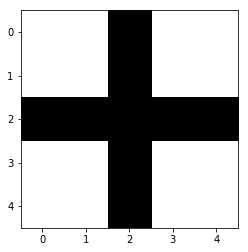

In [ ]:
plt.imshow(make_cross_image(), cmap="Greys");

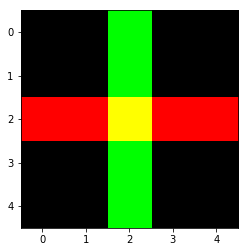

In [ ]:
plt.imshow(make_cross_image(False).permute(1,2,0));

In [ ]:
#export
def show_title(o, ax=None, ctx=None, label=None, **kwargs):
    "Set title of `ax` to `o`, or print `o` if `ax` is `None`"
    ax = ifnone(ax,ctx)
    if ax is None: print(o)
    elif hasattr(ax, 'set_title'): ax.set_title(o)
    elif isinstance(ax, pd.Series):
        while label in ax: label += '_'
        ax = ax.append(pd.Series({label: o}))
    return ax

In [ ]:
test_stdout(lambda: show_title("title"), "title")
# ensure that col names are unique when showing to a pandas series
assert show_title("title", ctx=pd.Series(dict(a=1)), label='a').equals(pd.Series(dict(a=1,a_='title')))

In [ ]:
#export
def show_image(im, ax=None, figsize=None, title=None, ctx=None, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    ax = ifnone(ax,ctx)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    # Handle pytorch axis order
    if isinstance(im,Tensor):
        im = to_cpu(im)
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=array(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

`show_image` can show b&w images...

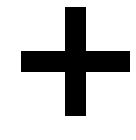

In [ ]:
im = make_cross_image()
ax = show_image(im, cmap="Greys", figsize=(2,2))

...and color images with standard `c*h*w` dim order...

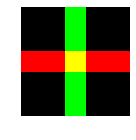

In [ ]:
im2 = make_cross_image(False)
ax = show_image(im2, figsize=(2,2))

...and color images with `h*w*c` dim order...

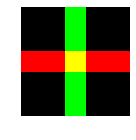

In [ ]:
im3 = im2.permute(1,2,0)
ax = show_image(im3, figsize=(2,2))

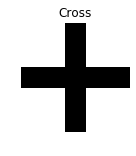

In [ ]:
ax = show_image(im, cmap="Greys", figsize=(2,2))
show_title("Cross", ax)

In [ ]:
#export
def show_titled_image(o, **kwargs):
    "Call `show_image` destructuring `o` to `(img,title)`"
    show_image(o[0], title=str(o[1]), **kwargs)

In [ ]:
#export
def show_image_batch(b, show=show_titled_image, items=9, cols=3, figsize=None, **kwargs):
    "Display batch `b` in a grid of size `items` with `cols` width"
    rows = (items+cols-1) // cols
    if figsize is None: figsize = (cols*3, rows*3)
    fig,axs = plt.subplots(rows, cols, figsize=figsize)
    for *o,ax in zip(*to_cpu(b), axs.flatten()): show(o, ax=ax, **kwargs)

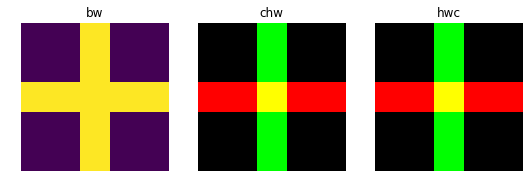

In [ ]:
show_image_batch(([im,im2,im3],['bw','chw','hwc']), items=3)

# Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_dataloader.ipynb.
Converted 01a_script.ipynb.
Converted 02_transforms.ipynb.
Converted 03_pipeline.ipynb.
Converted 04_data_external.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_test_models_core.ipynb.
Converted 34_callback_rnn.ipynb.
Converted 35_tutorial_wikitext.ipynb.
Converted 36_text_models_qrnn.ipynb.
Converted 40_tabula